In [2]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib. pyplot as plt
import seaborn as sns

# Hospital Admissions Prediction

### Goal
**Operational Planning**: Daily predictions could be useful for short-term operational planning, such as staffing, capacity management, and patient scheduling. These predictions could help ensure that there are sufficient resources available each day to meet patient needs.

**Strategic Planning**: Weekly or monthly predictions are more relevant for longer-term strategic planning, such as budgeting, resource allocation, or identifying trends and patterns over time.

--------

**Daily Predictions:** These are essential for day-to-day hospital management. Daily forecasts can provide guidance on how to allocate resources such as staff and medical supplies, and can help to manage patient scheduling on a short-term basis.

**Weekly Predictions:** Weekly forecasts are important for mid-term planning. They allow for the management of staff scheduling on a weekly basis, taking into account factors such as weekend demand or variations in demand throughout the week. Weekly predictions can also assist with the ordering and management of medical supplies.

**Monthly Predictions:** Monthly forecasts are key for long-term strategic planning. These predictions can guide decision-making around larger resource allocation issues, such as budgeting, monthly staffing rotations, or longer-term purchasing decisions for medical supplies. They are also useful for identifying and preparing for long-term trends or seasonal variations in demand.

In [3]:
path = '/Users/simonrahenbrock/Documents/thesis_code/datasets/'
df_adm = pd.read_csv(f'{path}HDHI Admission data.csv')
df_weather = pd.read_csv(f'{path}Ludhiana_historic_weather_preprocessed.csv')
df_poll = pd.read_csv(f'{path}HDHI Pollution Data.csv')
df_vehicles = pd.read_csv(f'{path}Ludhiana_Vehicles_Sales.csv')
df_ci = pd.read_csv(f'{path}AVG_ConsumerPriceIndex_Rice_Ludhiana.csv')

In [104]:
df_vehicles = pd.read_csv(f'{path}Ludhiana_Vehicles_Sales.csv')


In [327]:
df_india_food_ci = pd.read_csv(f'{path}CPI_Food_and_Beverages_India.csv')
df_india_alc_ci = pd.read_csv(f'{path}CPI_PanTobacco_and_Intoxicants_India.csv')

In [357]:
df_india_alc_ci_distributed = pd.read_csv(f'{path}CPI_PanTobacco_and_Intoxicants_India_distributed.csv')

In [370]:
df_india_alc_ci_distributed = pd.read_csv(f'{path}CPI_PanTobacco_and_Intoxicants_India_distributed.csv')


In [366]:
df_india_food_ci_distributed = pd.read_csv(f'{path}CPI_Food_and_Beverages_India_distributed.csv')

# 1 Data Cleaning and Preprocessing

## 1.2 Inspect Datetime 

In [263]:
# check all dates for order of datetime to investigate
# accounts for swapped formats as observed in dataset
def check_date(x):
    try:
        pd.to_datetime(x, format='%m/%d/%Y', errors='raise')
    except ValueError:
        try:
            pd.to_datetime(x, format='%d/%m/%Y', errors='raise')
        except ValueError:
            return x  # Return the problematic date

# create datetime for DOD and DOA
def parse_date(x):
    try:
        return pd.to_datetime(x, format='%m/%d/%Y', errors='raise')
    except ValueError:
        try:
            return pd.to_datetime(x, format='%d/%m/%Y', errors='raise')
        except ValueError:
            return pd.NaT  # Return a "Not a Time" for problematic dates

In [264]:
problem_dates_dod = df_adm['D.O.D'].apply(check_date)
print(problem_dates_dod[problem_dates_dod.notna()])
problem_dates_doa = df_adm['D.O.A'].apply(check_date)
print(problem_dates_doa[problem_dates_doa.notna()])

4692    2-1217
Name: D.O.D, dtype: object
Series([], Name: D.O.A, dtype: object)


In [265]:
df_adm.at[4692, 'D.O.D'] = '12/3/2017'
df_adm['D.O.D'] = df_adm['D.O.D'].apply(parse_date)
df_adm['D.O.A'] = df_adm['D.O.A'].apply(parse_date)

In [266]:
import datetime

def swap_day_month(date):
    """Swap day and month of a date if day >= 12."""
    try:
        return pd.to_datetime(f"{date.year}-{date.day}-{date.month}")
    except ValueError:
        return date

# Map month names to their numeric values
month_to_num = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

df_adm['corrected'] = (df_adm['D.O.D'] - df_adm['D.O.A']).dt.days + 1 == df_adm['DURATION OF STAY']

# before correcting rows
print('before: \n', df_adm['corrected'].value_counts())

def correct_dates(row):
    # Split the 'month-year' column into month and year
    month_str, year_str = row['month year'].split('-')
    correct_month = month_to_num[month_str]
    calculated_duration = (row['D.O.D'] - row['D.O.A']).days + 1

    if calculated_duration != row['DURATION OF STAY'] or row['D.O.A'].month != correct_month:
        # Store the original dates
        valid_dates = {'D.O.A': row['D.O.A'], 'D.O.D': row['D.O.D']}
        
        for date_type in ['D.O.A', 'D.O.D']:
            # Attempt to swap day and month
            swapped_date = swap_day_month(row[date_type])
            if date_type == 'D.O.A' and swapped_date.month == correct_month:
                valid_dates[date_type] = swapped_date

        # Update row with the swapped dates and check the new calculated duration
        row['D.O.A'] = valid_dates['D.O.A']
        row['D.O.D'] = valid_dates['D.O.D']
        new_calculated_duration = (row['D.O.D'] - row['D.O.A']).days + 1
        row['new_calculated_duration'] = new_calculated_duration

        # If the duration is still incorrect, try only swapping 'D.O.D'
        if new_calculated_duration != row['DURATION OF STAY']:
            swapped_date_dod = swap_day_month(row['D.O.D'])
            valid_dates['D.O.D'] = swapped_date_dod
            row['D.O.D'] = valid_dates['D.O.D']
            final_calculated_duration = (row['D.O.D'] - row['D.O.A']).days + 1
            row['new_calculated_duration'] = final_calculated_duration
            
            # Check if the final calculated duration is now correct
            if final_calculated_duration == row['DURATION OF STAY']:
                row['corrected'] = True
            else:
                row['corrected'] = False
        else:
            row['corrected'] = True
    else:
        row['corrected'] = True
        row['new_calculated_duration'] = row['DURATION OF STAY']
    return row



before: 
 corrected
True     10702
False     5055
Name: count, dtype: int64


In [267]:
# Apply the correction function to all rows
df_adm = df_adm.apply(correct_dates, axis=1)

print('after: \n', df_adm['corrected'].value_counts())

after: 
 corrected
True     15694
False       63
Name: count, dtype: int64


In [268]:
# Get the list of column names
cols = df_adm.columns.tolist()
to_arrange = ['MRD No.', 'D.O.A', 'D.O.D', 'month year', 'DURATION OF STAY', 'new_calculated_duration']

# Remove 'D.O.A' and 'D.O.D' from the list
for col in to_arrange:
    cols.remove(col)

# Insert them back at positions 3 and 4
for idx, col in enumerate(to_arrange):
    cols.insert(idx, col)

# Reorder the dataframe columns
df_adm = df_adm[cols]

df_adm[df_adm['corrected'] == False].iloc[:, :6].head()

,MRD No.,D.O.A,D.O.D,month year,DURATION OF STAY,new_calculated_duration
36,353253,2017-04-02,2017-05-04,Apr-17,11,33
40,380144,2017-04-02,2017-11-04,Apr-17,11,217
99,382409,2017-04-05,2017-11-14,Apr-17,10,224
180,368674,2017-04-14,2017-05-05,Apr-17,23,22
195,249474,2017-04-17,2017-01-05,Apr-17,16,-101


In [269]:
dfm_leftovers = df_adm[df_adm['corrected'] == False].iloc[:, :6]

def check_dates(row):
    """Check if swapping day and month results in correct duration."""
    original_duration = (row['D.O.D'] - row['D.O.A']).days + 1
    swapped_duration = (swap_day_month(row['D.O.D']) - (row['D.O.A'])).days + 1
    
    # Check if either the original or swapped duration is one more than 'DURATION OF STAY'
    if original_duration == row['DURATION OF STAY'] + 1:
        return 'og-duration == DURATIONS OF STAY + 1 '
    elif  swapped_duration == row['DURATION OF STAY'] + 1:
        return 'swapped-DOD-duration == DURATIONS OF STAY + 1 '
    else:
        return False

# Add a new 'check' column to the dataframe
dfm_leftovers['check'] = dfm_leftovers.apply(check_dates, axis=1)

print(dfm_leftovers[dfm_leftovers['check'] == False].shape)

dfm_leftovers[dfm_leftovers['check'] != False].head()

(30, 7)


,MRD No.,D.O.A,D.O.D,month year,DURATION OF STAY,new_calculated_duration,check
4692,316112,2017-11-27,2017-03-12,Nov-17,6,-259,swapped-DOD-duration == DURATIONS OF STAY + 1
5294,523699,2017-12-20,2018-01-04,Dec-17,15,16,og-duration == DURATIONS OF STAY + 1
5457,527141,2017-12-26,2018-01-04,Dec-17,9,10,og-duration == DURATIONS OF STAY + 1
5478,527708,2017-12-27,2018-01-03,Dec-17,7,8,og-duration == DURATIONS OF STAY + 1
5479,527295,2017-12-27,2018-01-03,Dec-17,7,8,og-duration == DURATIONS OF STAY + 1


so for 30 of the rows, we can either say the duration of stay variable or the D.O.D is false. There is no way of knowing, so we can either decide to drop those rows or assume that the one day will not make any difference and adjust the variables. The other 30 observations have different errors. However, since in total those 63 observations make for less than 0.5 % of the entire dataset, we can delete those rows to preserve the ingerity of the DURATION OF STAY variable.

In [270]:
dfm_leftovers_indeces = dfm_leftovers[dfm_leftovers['check'] != False].index.values.tolist()
df_adm = df_adm.drop(dfm_leftovers_indeces)

## 1.3 Duplicates and Readmissions

In [271]:
"""
create columns 'days since last discharge' and 'number of previous admission'
"""

# Add a new column for the previous discharge date for each patient
df_adm['previous_discharge_date'] = df_adm.groupby('MRD No.')['D.O.D'].shift(1)

# Calculate the number of days since the last discharge
df_adm['days_since_last_discharge'] = (df_adm['D.O.A'] - df_adm['previous_discharge_date']).dt.days

# Calculate the number of previous admissions
df_adm['number_of_previous_admissions'] = df_adm.groupby('MRD No.').cumcount()

# Create a Boolean mask for rows where 'days_since_last_discharge' is negative
mask = df_adm['days_since_last_discharge'] < 0

print('Number of rows to inspect: ', df_adm[mask].shape[0])

# Print out the rows with negative 'days_since_last_discharge'
df_adm[mask].head(10)

Number of rows to inspect:  1346


,MRD No.,D.O.A,D.O.D,month year,DURATION OF STAY,new_calculated_duration,SNO,AGE,GENDER,RURAL,...,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,corrected,previous_discharge_date,days_since_last_discharge,number_of_previous_admissions
16,413903,2017-04-01,2017-04-03,Apr-17,3,3,17,54,M,U,...,0,0,0,0,0,0,True,2017-04-05,-4.0,1
90,382159,2017-04-04,2017-04-09,Apr-17,6,6,91,47,F,U,...,0,0,0,0,0,0,True,2017-04-09,-5.0,1
95,48098,2017-04-05,2017-04-10,Apr-17,6,6,96,65,F,R,...,0,0,1,1,0,0,True,2017-04-10,-5.0,1
130,384232,2017-04-08,2017-04-12,Apr-17,5,5,131,80,F,U,...,0,0,0,0,0,0,True,2017-04-12,-4.0,1
147,203622,2017-04-10,2017-04-17,Apr-17,8,8,148,58,F,U,...,0,0,0,0,0,0,True,2017-04-17,-7.0,1
315,249647,2017-04-24,2017-05-08,Apr-17,15,15,316,80,M,U,...,0,0,1,1,0,0,True,2017-05-05,-11.0,1
320,250680,2017-04-24,2017-04-27,Apr-17,4,4,321,85,F,U,...,0,0,0,0,0,0,True,2017-04-27,-3.0,1
382,235427,2017-04-26,2017-04-28,Apr-17,3,3,383,56,M,U,...,0,0,0,0,0,0,True,2017-04-28,-2.0,1
461,253963,2017-04-29,2017-05-02,Apr-17,4,4,462,65,M,U,...,0,0,0,0,0,0,True,2017-05-02,-3.0,1
483,254699,2017-04-30,2017-05-08,Apr-17,9,9,484,68,M,U,...,0,0,0,0,0,0,True,2017-05-08,-8.0,1


In [272]:
duplicateRows = df_adm[df_adm.duplicated(['D.O.A', 'D.O.D', 'MRD No.'])]

# no actual readmissions, but duplicates where we have two admissions on the same day of the same patient
# only selecting where days_since_last_discharge is less than zero to exclude possible readmission on the same day
print(duplicateRows[duplicateRows['days_since_last_discharge'] < 0].shape)

# get indeces of double entries
duplicates_indeces = duplicateRows[duplicateRows['days_since_last_discharge'] < 0].index.values.tolist()

(1321, 61)


**Lastly, let's check the remaining rows**

In [273]:
# remaining rows to handle
df_adm_mask = df_adm[mask]

# Get the indices of rows in 'df_mask_no_nan' that are not in 'duplicateRows'
missing_indexes = df_adm_mask.index.difference(duplicateRows.index)

missing_indexes_no_nan = [index for index in missing_indexes if not pd.isna(df_adm.loc[index, 'days_since_last_discharge'])]

print(len(missing_indexes_no_nan))

# Now use 'missing_indexes' to subset 'df'
df_adm.loc[missing_indexes_no_nan].head()

25


,MRD No.,D.O.A,D.O.D,month year,DURATION OF STAY,new_calculated_duration,SNO,AGE,GENDER,RURAL,...,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,corrected,previous_discharge_date,days_since_last_discharge,number_of_previous_admissions
16,413903,2017-04-01,2017-04-03,Apr-17,3,3,17,54,M,U,...,0,0,0,0,0,0,True,2017-04-05,-4.0,1
315,249647,2017-04-24,2017-05-08,Apr-17,15,15,316,80,M,U,...,0,0,1,1,0,0,True,2017-05-05,-11.0,1
2401,147036,2017-08-06,2017-08-11,Aug-17,6,6,2402,70,M,U,...,0,0,0,0,0,0,True,2017-08-11,-5.0,1
2713,333052,2017-08-27,2017-09-02,Aug-17,7,7,2714,75,F,U,...,0,0,0,0,0,0,True,2017-08-31,-4.0,1
2754,300004,2017-08-29,2017-09-03,Aug-17,6,6,2755,62,M,U,...,0,0,0,0,0,0,True,2017-09-17,-19.0,2


In [274]:
# inspect rows
print("\n".join([df_adm[df_adm['MRD No.'] == mrd].iloc[:, :10].to_string() for mrd in df_adm.loc[missing_indexes_no_nan]['MRD No.']]))

     MRD No.      D.O.A      D.O.D month year  DURATION OF STAY  new_calculated_duration   SNO  AGE GENDER RURAL
15    413903 2017-04-01 2017-04-05     Apr-17                 5                        5    16   50      M     R
16    413903 2017-04-01 2017-04-03     Apr-17                 3                        3    17   54      M     U
5612  413903 2018-01-01 2018-01-02     Jan-18                 2                        2  5613   50      M     U
    MRD No.      D.O.A      D.O.D month year  DURATION OF STAY  new_calculated_duration  SNO  AGE GENDER RURAL
251  249647 2017-04-22 2017-05-05     Apr-17                14                       14  252   60      M     R
315  249647 2017-04-24 2017-05-08     Apr-17                15                       15  316   80      M     U
     MRD No.      D.O.A      D.O.D month year  DURATION OF STAY  new_calculated_duration   SNO  AGE GENDER RURAL
2307  147036 2017-08-01 2017-08-11     Aug-17                11                       11  2308   70   

Upon inspection, we can say that these rows have errors that require individual inspection. Simply deleting those could lead to deleting the wrong entry. For isntance, MRD No. '398799', has two entries but one is clearly wrong: the one not at index 5902, which is the counterpart to the entry in our missing_indeces dataframe.

After inspecting all 25 rows, we can infer the following:

* we can delete the rows at following indeces as those are conflicting entries that most likely are erros or we cannot logically infer otherwise: 
* 16, 2307, 2554, 2754, 3326, 3607,, 5780, 6191, 7443, 7838, 3934,  5566, 5780,  6191, 7326, 9365, 7684, 7698, 10113, 11052, 12602, 13911
* the following rows have other issues:
    * 6722 has dod's month and day swapped
    * 251 and 315 are most likely different patients
    * 3910 different patient 
    * 8979 different patient
    * 10169 might be a different patient
    * 11133 might be a different patient
    * 12593 different patient
    * 13358 might be a different patient
    * 15350 might be a different patient
    * 12667 new patient

In [275]:
df_adm = df_adm.drop(index=duplicates_indeces)
df_adm.loc[6722, 'D.O.D'] = swap_day_month(df_adm.loc[6722, 'D.O.D'])
delete_indices = [16, 2307, 2554, 2754, 
                  3326, 3607, 5780, 6191, 
                  7443, 7838, 3934, 5566, 
                  5780, 6191, 9365, 7684, 
                  10113, 11052, 12602, 13911, 
                  2812, 7473]
ambiguous_indices = [251, 315, 3910, 8979, 
                     10169, 11133, 12593, 
                     13358, 15350, 12667]
df_adm = df_adm.drop(index=ambiguous_indices)
df_adm = df_adm.drop(index=delete_indices)

**Finally, let's revisit the function that allowed us to compute readmission and further investigate duplicates to see whether there is still anything left to handle. This will also update the readmission specific columns**

In [276]:
df_cpy = df_adm.copy()

def readmission_features(df):
    # Add a new column for the previous discharge date for each patient
    df['previous_discharge_date'] = df.groupby('MRD No.')['D.O.D'].shift(1)

    # Calculate the number of days since the last discharge
    df['days_since_last_discharge'] = (df['D.O.A'] - df['previous_discharge_date']).dt.days

    # Calculate the number of previous admissions
    df['number_of_previous_admissions'] = df.groupby('MRD No.').cumcount()
    
    return df
    
df_cpy = readmission_features(df_cpy)

# Create a Boolean mask for rows where 'days_since_last_discharge' is negative
mask = df_cpy['days_since_last_discharge'] < 0

print('Number of rows to inspect: ', df_cpy[mask].shape[0])

# Print out the rows with negative 'days_since_last_discharge'
df_cpy[mask].head(10)

Number of rows to inspect:  0


,MRD No.,D.O.A,D.O.D,month year,DURATION OF STAY,new_calculated_duration,SNO,AGE,GENDER,RURAL,...,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,corrected,previous_discharge_date,days_since_last_discharge,number_of_previous_admissions


## 1.4 Data Preprocessing

In [277]:
# change variable name seperators
df_cpy.columns = (column.replace(" ", "_").replace("/", 
                  "_").replace("&", "_").replace("-",
                  "_").replace("(", "_").replace(")", "_")
                  for column in df_cpy.columns)

# to numericals
to_numeric = ['HB', 'TLC', 'PLATELETS', 'GLUCOSE', 'UREA', 'CREATININE', 'BNP', 'EF']

for col in to_numeric:
    df_cpy[col] = df_cpy[col].replace('EMPTY', np.nan)
    df_cpy[col] = pd.to_numeric(df_cpy[col], errors='coerce')
    
# binary encoding
binary_map = lambda x: x.map({binary_dict[x.name][0]: 1, binary_dict[x.name][1]: 0})

# this row has a '\\' in Chest_Infection
df_cpy = df_cpy.drop(df_cpy[df_cpy['SNO'] == 3253].index)


# encoding Attrition and Overtime
binary_dict = {'RURAL':  ('R', 'U'),
               'GENDER': ('M', 'F') , 
               'TYPE_OF_ADMISSION_EMERGENCY_OPD' : ('E', 'O'),
               # here, the order of (1,0) matters
               'CHEST_INFECTION' : ('1', '0')
               }
# binary encoding
features = list(binary_dict.keys())
df_cpy[features] = df_cpy[features].apply(binary_map)

# drop unnecssary features
df_cpy = df_cpy.drop(['MRD_No.', 
                      'new_calculated_duration', 'corrected', 
                      'month_year', 'SNO', 'previous_discharge_date', 
                      'days_since_last_discharge'], axis=1)



In [278]:
df_cpy = pd.get_dummies(df_cpy, prefix='Outcome', columns=['OUTCOME'])

# Convert boolean values to int
for col in df_cpy.columns:
    if 'Outcome_' in col:
        df_cpy[col] = df_cpy[col].astype(int)

In [279]:
# create Time-Series Dataime Object
df_cpy.set_index('D.O.A', inplace=True)
df_cpy

,D.O.D,DURATION_OF_STAY,AGE,GENDER,RURAL,TYPE_OF_ADMISSION_EMERGENCY_OPD,duration_of_intensive_unit_stay,SMOKING_,ALCOHOL,DM,...,INFECTIVE_ENDOCARDITIS,DVT,CARDIOGENIC_SHOCK,SHOCK,PULMONARY_EMBOLISM,CHEST_INFECTION,number_of_previous_admissions,Outcome_DAMA,Outcome_DISCHARGE,Outcome_EXPIRY
D.O.A,,,,,,,,,,,,,,,,,,,,,
2017-04-01,2017-04-03,3,81,1,1,1,2,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2017-04-01,2017-04-05,5,65,1,1,1,2,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2017-04-01,2017-04-03,3,53,1,0,1,3,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2017-04-01,2017-04-08,8,67,0,0,1,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2017-04-01,2017-04-23,23,60,0,0,1,9,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31,2019-04-08,9,60,0,0,1,9,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2019-03-31,2019-04-04,5,86,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2019-03-31,2019-04-01,2,50,1,1,1,2,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### 1.4 Missing Values

The previous study created models predicting health outcomes and more using this dataset. They used the k-Nearest Neighbors (KNN) approach using Euclidean distance metric for imputing missing values. In particular, each missing feature was imputed using average feature value from k = 10 nearest neighbors. So, let's use this proven method.

In [280]:
df_cpy.isna().sum()

D.O.D                                 0
DURATION_OF_STAY                      0
AGE                                   0
GENDER                                0
RURAL                                 0
TYPE_OF_ADMISSION_EMERGENCY_OPD       0
duration_of_intensive_unit_stay       0
SMOKING_                              0
ALCOHOL                               0
DM                                    0
HTN                                   0
CAD                                   0
PRIOR_CMP                             0
CKD                                   0
HB                                  251
TLC                                 281
PLATELETS                           286
GLUCOSE                             897
UREA                                239
CREATININE                          245
BNP                                8416
RAISED_CARDIAC_ENZYMES                0
EF                                 1473
SEVERE_ANAEMIA                        0
ANAEMIA                               0


In [281]:
# k-NN for missing values
from sklearn.impute import KNNImputer

# Create a KNN Imputer
imputer = KNNImputer(n_neighbors=10)

# Define columns to impute
columns_to_impute = ['HB', 'TLC', 'PLATELETS', 'GLUCOSE', 'UREA', 'CREATININE', 'BNP', 'EF', ]

# Apply the imputer
df_cpy[columns_to_impute] = imputer.fit_transform(df_cpy[columns_to_impute])

### 1.5 Inspect Outliers

Let's start with a viusal inspection and then using the IQR

In [282]:
df_cpy.describe()

,D.O.D,DURATION_OF_STAY,AGE,GENDER,RURAL,TYPE_OF_ADMISSION_EMERGENCY_OPD,duration_of_intensive_unit_stay,SMOKING_,ALCOHOL,DM,...,INFECTIVE_ENDOCARDITIS,DVT,CARDIOGENIC_SHOCK,SHOCK,PULMONARY_EMBOLISM,CHEST_INFECTION,number_of_previous_admissions,Outcome_DAMA,Outcome_DISCHARGE,Outcome_EXPIRY
count,14372,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,...,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000
mean,2018-04-15 11:08:48.026718464,6.351169,61.386585,0.634150,0.238659,0.701225,3.771987,0.051906,0.066797,0.330225,...,0.001879,0.013429,0.062761,0.049819,0.015377,0.022753,0.218063,0.057612,0.866059,0.076329
min,2017-01-05 00:00:00,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017-10-18 00:00:00,3.000000,54.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2018-04-09 00:00:00,5.000000,62.000000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2018-10-26 00:00:00,8.000000,70.000000,1.000000,0.000000,1.000000,5.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2019-04-23 00:00:00,98.000000,110.000000,1.000000,1.000000,1.000000,58.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,1.000000,1.000000,1.000000
std,NaN,5.015394,13.434528,0.481685,0.426278,0.457737,4.004067,0.221846,0.249678,0.470311,...,0.043304,0.115106,0.242541,0.217579,0.123052,0.149119,0.677716,0.233016,0.340601,0.265533


In [283]:
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3*IQR # 3* extreme outliers
    upper_bound = Q3 + 3*IQR # 3* for extreme outliers

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [284]:
outliers = find_outliers(df_cpy, 'DURATION_OF_STAY')
outliers

,D.O.D,DURATION_OF_STAY,AGE,GENDER,RURAL,TYPE_OF_ADMISSION_EMERGENCY_OPD,duration_of_intensive_unit_stay,SMOKING_,ALCOHOL,DM,...,INFECTIVE_ENDOCARDITIS,DVT,CARDIOGENIC_SHOCK,SHOCK,PULMONARY_EMBOLISM,CHEST_INFECTION,number_of_previous_admissions,Outcome_DAMA,Outcome_DISCHARGE,Outcome_EXPIRY
D.O.A,,,,,,,,,,,,,,,,,,,,,
2017-04-06,2017-05-11,36,89,0,0,1,36,0,0,0,...,0,0,1,1,0,0,0,0,0,1
2017-04-10,2017-05-07,28,62,0,0,1,10,0,0,0,...,0,0,1,1,0,0,0,0,0,1
2017-04-12,2017-05-13,32,61,1,0,1,2,0,0,0,...,0,0,1,1,0,0,1,0,0,1
2017-04-12,2017-05-13,32,64,1,0,1,2,0,0,1,...,0,0,1,1,0,0,0,0,0,1
2017-04-19,2017-05-12,24,88,1,0,1,24,0,0,0,...,0,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-02,2019-03-29,28,55,1,0,1,21,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-03-08,2019-04-01,25,80,0,0,1,18,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2019-03-13,2019-04-10,29,60,1,0,1,14,0,0,0,...,0,0,0,0,0,0,0,0,1,0


without medical domain knowledge it is impossible to gauge whether outliers are actual errors or so unusual that they do not indicate important features or patterns in the data. Therefore, we can keep outliers. The previous study removed outliers in Duration of Stay, using the interquartile range. Assuming the authors were in contact with the hospital and had access to medical knowledge, we could safely remove those outlieres. We could also only remove 'extreme' outliers, where delta=3*IQR isnstead of 1.5*IQR. However, since we are predicting total hospital admissions we need to aggregate these features. Here, not loosing out on daily observations is key and taking the median of these columns can be an alternative solution.

# 2 Initital Exploratory Data Analysis

In [285]:
print(df_cpy['GENDER'].value_counts())
print(df_cpy['RURAL'].value_counts())
print(df_cpy['TYPE_OF_ADMISSION_EMERGENCY_OPD'].value_counts())
print(df_adm['OUTCOME'].value_counts())

GENDER
1    9114
0    5258
Name: count, dtype: int64
RURAL
0    10942
1     3430
Name: count, dtype: int64
TYPE_OF_ADMISSION_EMERGENCY_OPD
1    10078
0     4294
Name: count, dtype: int64
OUTCOME
DISCHARGE    12448
EXPIRY        1097
DAMA           828
Name: count, dtype: int64


In [286]:
#df_cpy = df_cpy[df_cpy['TYPE_OF_ADMISSION_EMERGENCY_OPD'] == 1]

In [287]:
df_cpy[df_cpy['STEMI'] == 1].shape

(2034, 55)

**Let's visualize daily, weekly, and monthly total admissions after cleaning the time-data**

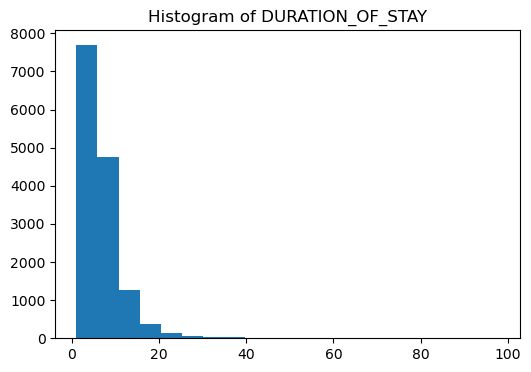

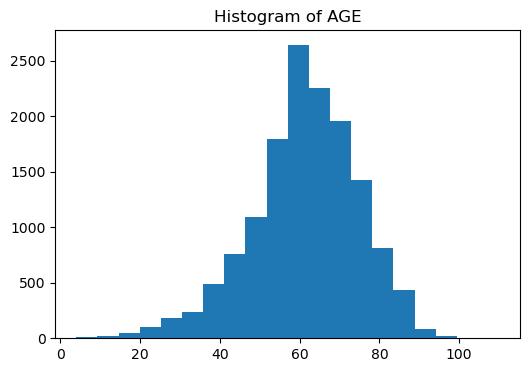

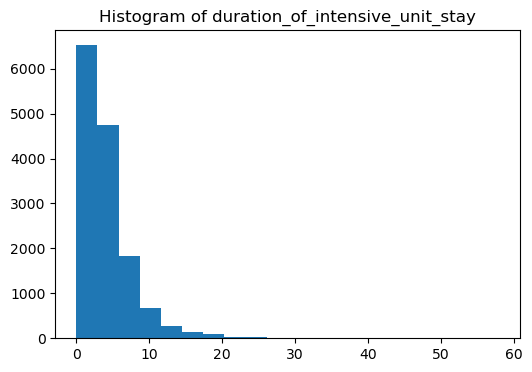

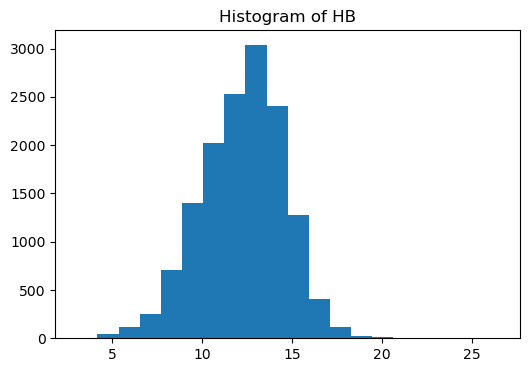

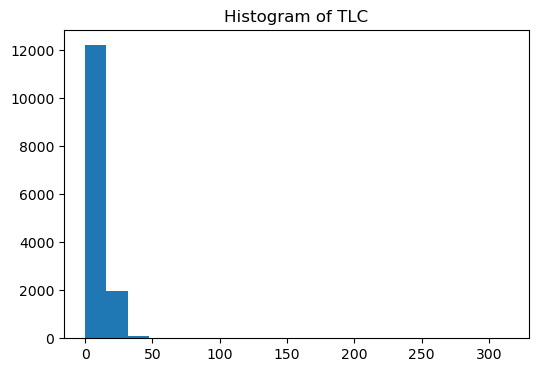

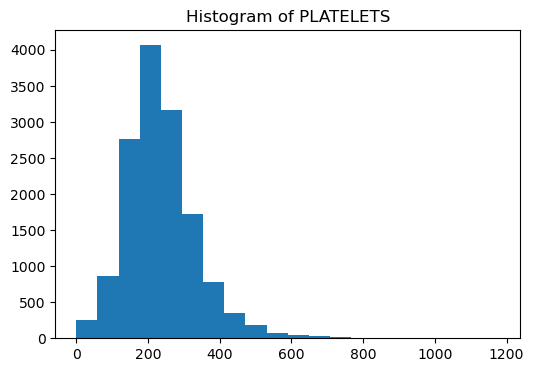

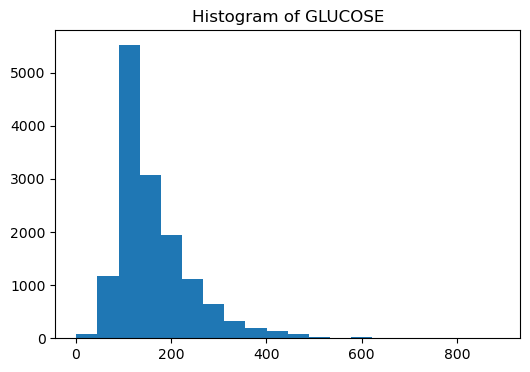

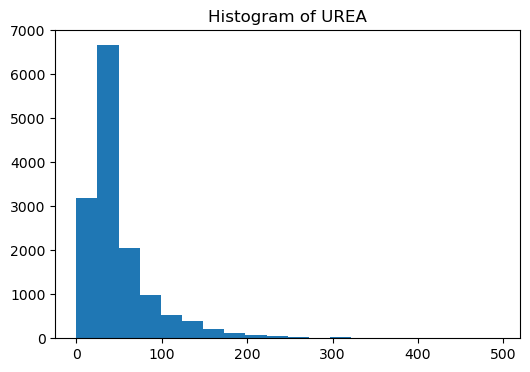

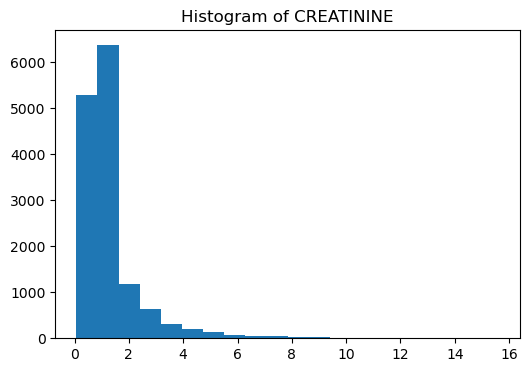

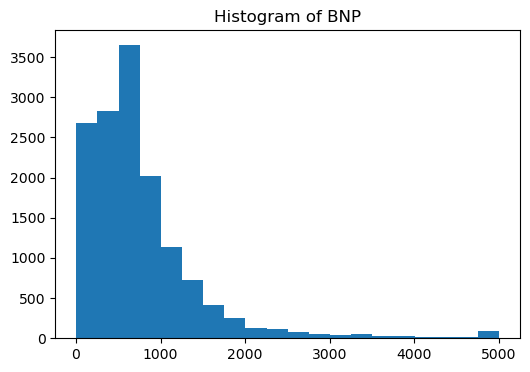

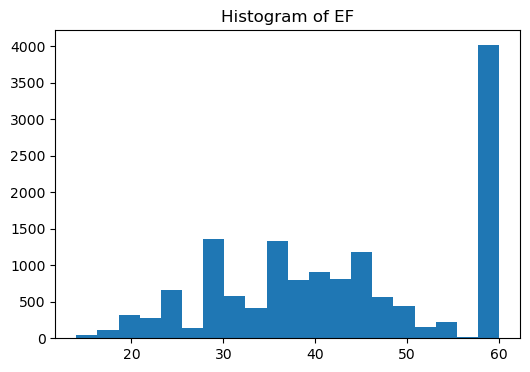

In [288]:
df_cpy_reset = df_cpy.reset_index()

to_plot = ['DURATION_OF_STAY', 'AGE', 'duration_of_intensive_unit_stay', 
           'HB', 'TLC', 'PLATELETS', 'GLUCOSE', 'UREA', 
           'CREATININE', 'BNP', 'EF']

for column in to_plot:
    plt.figure(figsize=(6, 4))  # Adjust the figure size as per your preference
    plt.hist(data=df_cpy_reset, x=column, bins=20)
    plt.title(f'Histogram of {column}')
    plt.show()

# 3 Time-Series Feature Engineering

We have multiple patient-level features, which we need to aggregate in a meaningful way to inform our time-series forecast.

The following features could be relevant to include in our time-series:

* Type of Admission: Count or ratio of the types of admissions (Emergency vs OPD) for each time period. This can help distinguish between periods with higher emergency cases versus regular checkups.

* Health Indicators: The average or median values of certain health indicators such as glucose, creatinine, BNP, and other vitals could be informative.

* Patient History:  count the number of patients with a history of smoking, alcohol use, diabetes, hypertension, chronic kidney disease, and other health conditions per time period.

* Common Conditions: Calculate the count or ratio of common conditions such as anaemia, angina, heart failure, valvular disease, stroke, atrial fibrillation, etc.

* Outcomes: The number of patients discharged or readmitted during each time period.

* Patient Demographics: Ratio of rural vs urban patients, ratio of genders, and average or median age.

* Medical Tests: Average values of blood tests or other medical tests (Hemoglobin, Platelets, etc.)

* Readmissions: Total number of readmissions for time period

Intuitively, these patient-level datapoint will be less predictive of total hospital admissions than pollution or weather data because these patient level data are records after the fact as opposed to pollution or weather data that have shown to cause or amplify cardiovascular diseases. However, patient-level data might be interesting for predicting readmissions for future work. Let's engineer patient-level data nonetheless and select the best features later.

## 3.1 Feature Aggregation for Time-Series -

Finally, let's create new features for our time-series. We first inspect the ditribution of the numerical variables.

In [295]:
#df_cpy_2 = df_cpy[df_cpy['TYPE_OF_ADMISSION_EMERGENCY_OPD'] == 1]

def aggregate_by_day(df, groupby_col, agg_col, method='sum'):
    """ 
    Designed to handle specific columns
    that would create data leakage
    if aggregated on DOA instead of DOD
    """
    df[groupby_col] = pd.to_datetime(df[groupby_col])
    if method == 'sum':
        grouped = df.groupby(df[groupby_col].dt.date)[agg_col].sum()
    elif method == 'average':
        grouped = df.groupby(df[groupby_col].dt.date)[agg_col].mean()
    elif method == 'median':
        grouped = df.groupby(df[groupby_col].dt.date)[agg_col].median()
    agg_df = pd.DataFrame()
    agg_df[agg_col+'_'+method] = grouped
    agg_df.index = pd.to_datetime(agg_df.index)
    return agg_df

# Group by 'ADMISSION_DATE' 
grouped = df_cpy.groupby(df_cpy.index.date)

# Count of Admissions
df_features = pd.DataFrame()
df_features['total_admissions'] = grouped.size()

# Use the function to aggregate 'DURATION_OF_STAY', 'INTENSIVE_UNIT_STAY', 'EXPIRY', 'DAMA'
"""Using DOD instead of DOA prevents data leakage
because we are NOT keeping information of how 
long people have stayed in the hospital before they left the hospital"""
df_duration = aggregate_by_day(df_cpy, 'D.O.D', 'DURATION_OF_STAY', method='median')
df_intensive = aggregate_by_day(df_cpy, 'D.O.D', 'duration_of_intensive_unit_stay', method='median')
df_expiry = aggregate_by_day(df_cpy, 'D.O.D', 'Outcome_EXPIRY')
df_dama = aggregate_by_day(df_cpy, 'D.O.D', 'Outcome_DAMA')
df_discharge = aggregate_by_day(df_cpy, 'D.O.D', 'Outcome_DISCHARGE')

# Join the new dataframes with df_features
df_features = df_features.join(df_duration, how='left').dropna()
df_features = df_features.join(df_intensive, how='left').dropna()
df_features = df_features.join(df_expiry, how='left').dropna()
df_features = df_features.join(df_dama, how='left').dropna()
df_features = df_features.join(df_discharge, how='left').dropna()

# Health Indicators
for col in ['TLC', 'PLATELETS',
            'GLUCOSE', 'UREA', 'CREATININE',
            'BNP', 'EF',]:
    df_features[col+'_median'] = grouped[col].median()
    
df_features['HB_mean'] = grouped['HB'].mean()

# Patient History and type of admissions
for col in ['SMOKING_', 'ALCOHOL', 'DM', 'HTN', 'PRIOR_CMP', 'CKD', 'TYPE_OF_ADMISSION_EMERGENCY_OPD']:
    df_features[col+'_sum'] = grouped[col].sum()

# Common Conditions
for col in ['SEVERE_ANAEMIA', 'ANAEMIA', 'STABLE_ANGINA', 'ACS', 'STEMI', 'ATYPICAL_CHEST_PAIN', 
            'HEART_FAILURE', 'HFREF', 'HFNEF', 'VALVULAR', 'CAD']:
    df_features[col+'_sum'] = grouped[col].sum()

# Patient Demographics
df_features['average_age'] = grouped['AGE'].mean()
df_features['male_ratio'] = grouped['GENDER'].mean()  # assuming male=1 and female=0
df_features['rural_ratio'] = grouped['RURAL'].mean()
#df_features['Emergency_to_Outpatient_ratio'] = grouped['TYPE_OF_ADMISSION_EMERGENCY_OPD'].mean()

# Readmissions
df_features['readmissions_sum'] = grouped['number_of_previous_admissions'].sum()

# make sure index is set to datetime
df_features.index = pd.to_datetime(df_features.index)

In [297]:
# Create a KNN Imputer
imputer = KNNImputer(n_neighbors=10)

# Define columns to impute
columns_to_impute = ['CREATININE_median']

# Apply the imputer
df_features[columns_to_impute] = imputer.fit_transform(df_features[columns_to_impute])

**After feature aggregation we need to check whether there are any missing dates**

In [220]:
def fill_missing_dates(df):
    df.sort_index(inplace=True)
    # Create new date range that includes all dates in the given range
    all_dates = pd.date_range(start=df.index.min(), end=df.index.max())
    
    # Check if all dates in the range are in the DataFrame's index
    missing_dates = all_dates[~all_dates.isin(df.index)]
    
    print(missing_dates)
    
    # Re-index dataframe to include all dates
    df = df.reindex(all_dates)
    
    # Iterate over missing dates and fill them
    for date in missing_dates:
        # if the year is 2018 or 2019, use data from the same date previous year if available
        previous_year_date = date - pd.DateOffset(years=1)
        if previous_year_date in df.index and not pd.isna(df.loc[previous_year_date]).any():
            df.loc[date] = df.loc[previous_year_date]
            #print("Filled: ", df.loc[date])
        else:
            # if previous year data is not available, use forward fill
            df.loc[date] = df.loc[date].fillna(method='bfill', limit=1)     
    return df


# Fill missing values in each dataframe
df_features = fill_missing_dates(df_features)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


# 2 Weather and Pollution Data

For cardiovascular diseases, the pollutants that are most often mentioned in the literature as having an impact are as follows:

* PM2.5 (Fine Particulate Matter): Multiple studies have demonstrated a significant association between exposure to PM2.5 and cardiovascular morbidity and mortality. These fine particles can penetrate deep into the lungs and into the bloodstream, causing inflammation and exacerbating heart and lung diseases.

* PM10 (Coarse Particulate Matter): Though less dangerous than PM2.5, PM10 can also be harmful, particularly in high concentrations. These particles can also enter the respiratory tract.

* NO2 (Nitrogen Dioxide): Exposure to nitrogen dioxide has been linked to increased cardiovascular hospital admissions and mortality. In many urban areas, traffic is a major source of NO2.

* Ozone: Short-term exposure to ozone has been linked with a range of cardiovascular effects including heart attacks, arrhythmias, and worsening of heart failure. However, the effects of long-term exposure are less clear.

* CO (Carbon Monoxide): High levels of carbon monoxide can cause cardiovascular harm by reducing the amount of oxygen that can be transported in the blood. However, outdoor levels of CO are generally much lower than indoor levels, and outdoor CO is usually not considered a major risk factor for cardiovascular disease.

* SO2 (Sulfur Dioxide): The link between SO2 and cardiovascular diseases is less strong and direct compared to other pollutants. However, some studies have indicated a potential association between short-term SO2 exposure and increased rates of hospital admissions for cardiovascular conditions.

* AQI (Air Quality Index): As a composite measure of overall air quality, AQI can certainly be relevant to cardiovascular health, particularly when it's driven by high levels of the pollutants mentioned above.

In [55]:
df_poll = pd.read_csv(f'{path}HDHI Pollution Data.csv')

In [56]:
df_poll.head()

,DATE,AQI,PM2.5 AVG,PM2.5 MIN,PM2.5 MAX,PM10 AVG,PM10 MIN,PM10 MAX,NO2 AVG,NO2 MIN,...,CO AVG,CO MIN,CO MAX,OZONE AVG,OZONE MIN,OZONE MAX,PROMINENT POLLUTENT,MAX TEMP,MIN TEMP,HUMIDITY
0,3/25/2017,75,75,45,210,74,50,110,28,40,...,34,1,49,38,21,70,PM2.5,36,18,32.0
1,3/26/2017,82,82,47,153,75,65,86,29,26,...,32,7,55,30,8,70,PM2.5,38,19,23.0
2,3/27/2017,72,72,63,150,71,45,98,38,34,...,40,10,68,26,18,53,PM2.5,40,20,14.0
3,3/28/2017,80,78,63,88,80,73,87,39,37,...,25,12,48,21,4,71,PM10,40,21,36.0
4,3/29/2017,73,64,53,75,73,63,86,38,36,...,35,20,54,32,6,56,PM10,40,23,31.0


In [57]:
df_poll.columns

Index(['DATE', 'AQI', 'PM2.5 AVG', 'PM2.5 MIN', 'PM2.5 MAX', 'PM10 AVG',
       'PM10 MIN', 'PM10 MAX', 'NO2 AVG', 'NO2 MIN', 'NO2 MAX', 'NH3 AVG',
       'NH3 MIN', 'NH3 MAX', 'SO2 AVG', 'SO2 MIN', 'SO2 MAX', 'CO AVG',
       'CO MIN', 'CO MAX', 'OZONE AVG', 'OZONE MIN', 'OZONE MAX',
       'PROMINENT POLLUTENT', 'MAX TEMP', 'MIN TEMP', 'HUMIDITY'],
      dtype='object')

In [58]:
df_poll.describe()

,AQI,PM2.5 AVG,PM2.5 MIN,PM2.5 MAX,PM10 AVG,PM10 MIN,NO2 AVG,NO2 MIN,NH3 AVG,NH3 MIN,...,SO2 MIN,SO2 MAX,CO AVG,CO MIN,CO MAX,OZONE AVG,OZONE MIN,MAX TEMP,MIN TEMP,HUMIDITY
count,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,...,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,733.000000
mean,127.477612,111.949796,51.985075,200.017639,113.526459,68.687924,32.594301,22.443691,6.393487,4.900950,...,3.495251,25.234735,35.484396,15.868385,62.305292,22.781547,9.096336,32.260516,20.065129,40.618008
std,82.960653,75.889697,45.899300,112.484810,69.938247,42.054575,54.859179,29.397850,9.929499,4.671515,...,2.890726,20.600311,14.637934,10.171774,25.485351,13.464316,6.631832,7.471502,7.687235,17.951781
min,28.000000,11.000000,1.000000,18.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,3.000000,5.000000,1.000000,7.000000,3.000000,1.000000,17.000000,5.000000,5.000000
25%,77.000000,62.000000,23.000000,100.000000,71.000000,38.000000,14.000000,7.000000,1.000000,1.000000,...,1.000000,12.000000,26.000000,8.000000,45.000000,12.000000,4.000000,26.000000,13.000000,26.000000
50%,105.000000,91.000000,43.000000,180.000000,94.000000,62.000000,16.000000,13.000000,4.000000,3.000000,...,2.000000,20.000000,35.000000,15.000000,57.000000,19.000000,8.000000,34.000000,21.000000,38.000000
75%,151.000000,134.000000,67.000000,296.000000,134.000000,87.000000,30.000000,25.000000,10.000000,9.000000,...,5.000000,29.000000,43.000000,23.000000,78.000000,32.000000,11.000000,38.000000,27.000000,54.000000
max,797.000000,419.000000,317.000000,500.000000,486.000000,265.000000,797.000000,270.000000,188.000000,19.000000,...,19.000000,157.000000,100.000000,48.000000,183.000000,78.000000,46.000000,48.000000,34.000000,92.000000


In [59]:
df_poll['PROMINENT POLLUTENT'].value_counts()

PROMINENT POLLUTENT
PM10     374
PM2.5    319
CO        31
NO2       11
SO2        2
Name: count, dtype: int64

## 2.1 Data Preprocessing

In [60]:
df_poll.isna().sum()

DATE                   0
AQI                    0
PM2.5 AVG              0
PM2.5 MIN              0
PM2.5 MAX              0
PM10 AVG               0
PM10 MIN               0
PM10 MAX               0
NO2 AVG                0
NO2 MIN                0
NO2 MAX                0
NH3 AVG                0
NH3 MIN                0
NH3 MAX                0
SO2 AVG                0
SO2 MIN                0
SO2 MAX                0
CO AVG                 0
CO MIN                 0
CO MAX                 0
OZONE AVG              0
OZONE MIN              0
OZONE MAX              0
PROMINENT POLLUTENT    0
MAX TEMP               0
MIN TEMP               0
HUMIDITY               4
dtype: int64

In [61]:
df_poll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 737 non-null    object 
 1   AQI                  737 non-null    int64  
 2   PM2.5 AVG            737 non-null    int64  
 3   PM2.5 MIN            737 non-null    int64  
 4   PM2.5 MAX            737 non-null    int64  
 5   PM10 AVG             737 non-null    int64  
 6   PM10 MIN             737 non-null    int64  
 7   PM10 MAX             737 non-null    object 
 8   NO2 AVG              737 non-null    int64  
 9   NO2 MIN              737 non-null    int64  
 10  NO2 MAX              737 non-null    object 
 11  NH3 AVG              737 non-null    int64  
 12  NH3 MIN              737 non-null    int64  
 13  NH3 MAX              737 non-null    int64  
 14  SO2 AVG              737 non-null    int64  
 15  SO2 MIN              737 non-null    int

In [62]:
df_poll.select_dtypes('object')

,DATE,PM10 MAX,NO2 MAX,OZONE MAX,PROMINENT POLLUTENT
0,3/25/2017,110,180,70,PM2.5
1,3/26/2017,86,31,70,PM2.5
2,3/27/2017,98,40,53,PM2.5
3,3/28/2017,87,40,71,PM10
4,3/29/2017,86,41,56,PM10
...,...,...,...,...,...
732,3/27/2019,122,3,58,PM2.5
733,3/28/2019,122,3,58,PM2.5
734,3/29/2019,103,17,67,PM10
735,3/30/2019,112,51,71,PM2.5


In [63]:
df_poll.columns

Index(['DATE', 'AQI', 'PM2.5 AVG', 'PM2.5 MIN', 'PM2.5 MAX', 'PM10 AVG',
       'PM10 MIN', 'PM10 MAX', 'NO2 AVG', 'NO2 MIN', 'NO2 MAX', 'NH3 AVG',
       'NH3 MIN', 'NH3 MAX', 'SO2 AVG', 'SO2 MIN', 'SO2 MAX', 'CO AVG',
       'CO MIN', 'CO MAX', 'OZONE AVG', 'OZONE MIN', 'OZONE MAX',
       'PROMINENT POLLUTENT', 'MAX TEMP', 'MIN TEMP', 'HUMIDITY'],
      dtype='object')

In [64]:
df_poll['PM2.5 AVG'].mean()

111.94979647218453

In [65]:
# Convert to numeric
for col in ['PM10 MAX', 'NO2 MAX', 'OZONE MAX']:
    df_poll[col] = pd.to_numeric(df_poll[col], errors='coerce')

# Dummy encoding
df_poll = pd.get_dummies(df_poll, columns=['PROMINENT POLLUTENT'], dtype=int)

df_poll.drop(['AQI','PM10 MIN', 'PM10 MAX', 'NO2 AVG', 'NO2 MIN', 'NO2 MAX', 'NH3 AVG',
       'NH3 MIN', 'NH3 MAX', 'SO2 AVG', 'SO2 MIN', 'SO2 MAX', 'CO AVG',
       'CO MIN', 'CO MAX', 'OZONE AVG', 'OZONE MIN', 'OZONE MAX',
       'PROMINENT POLLUTENT_CO', 'PM2.5 MIN',
       'PROMINENT POLLUTENT_NO2', 'PROMINENT POLLUTENT_PM10',
       'PROMINENT POLLUTENT_PM2.5', 'PROMINENT POLLUTENT_SO2', 'MAX TEMP', 'MIN TEMP', 'HUMIDITY'], axis=1, inplace=True)

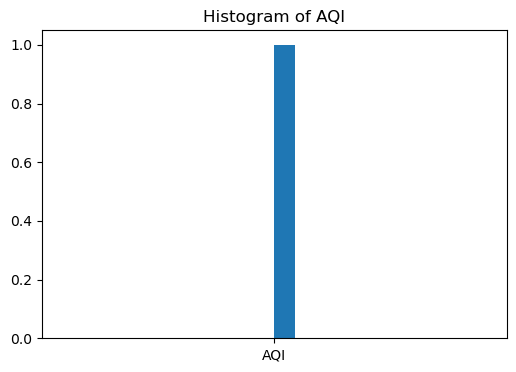

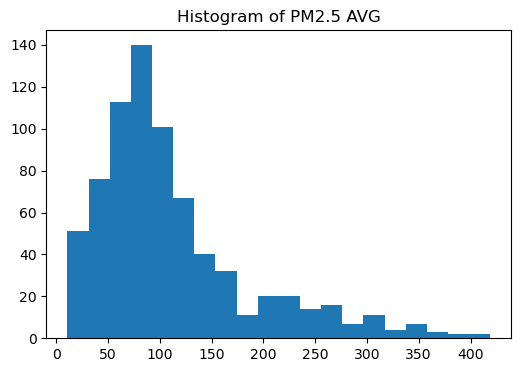

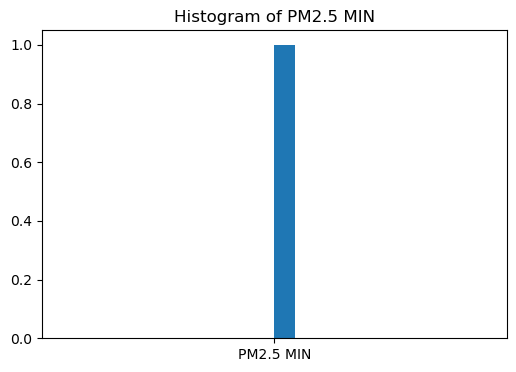

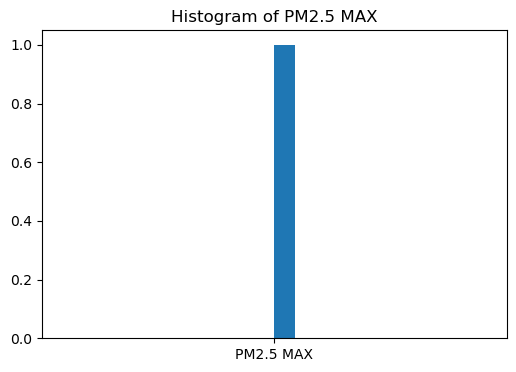

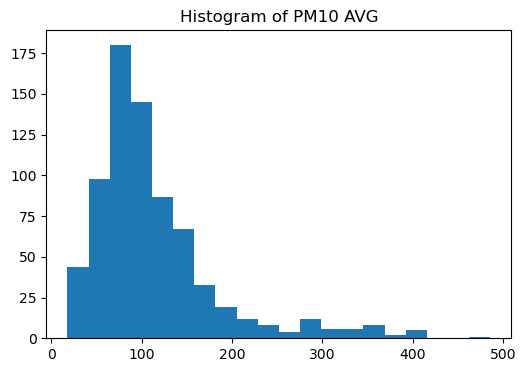

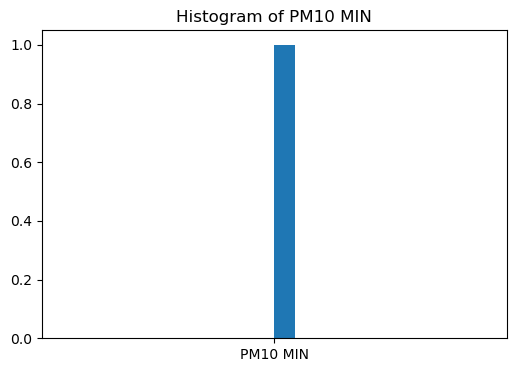

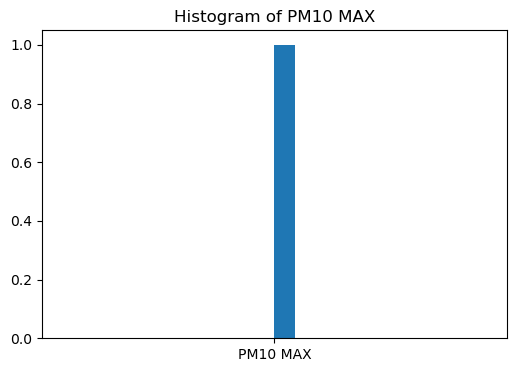

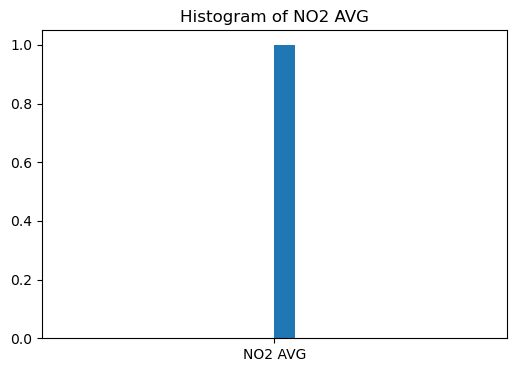

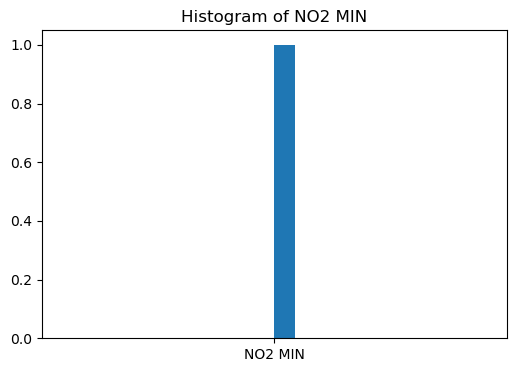

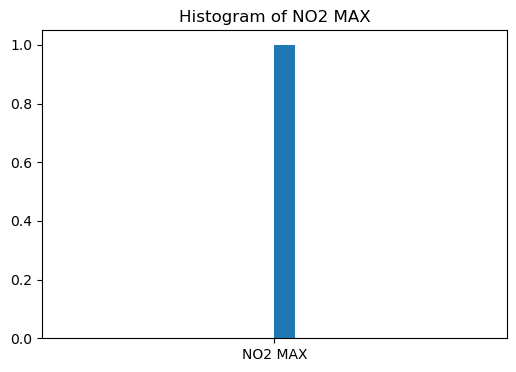

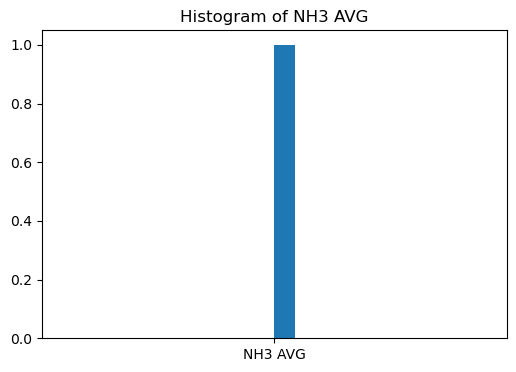

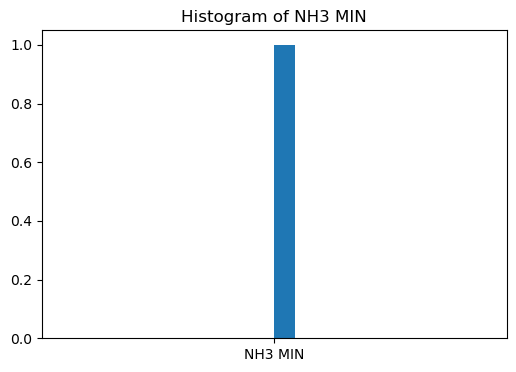

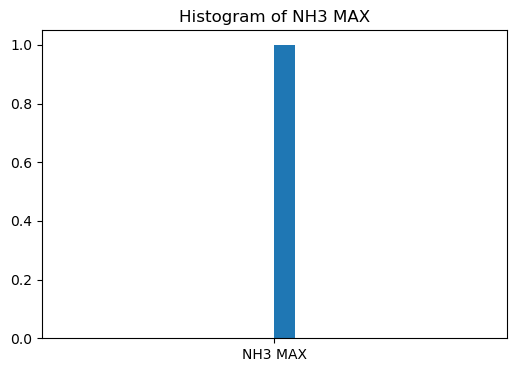

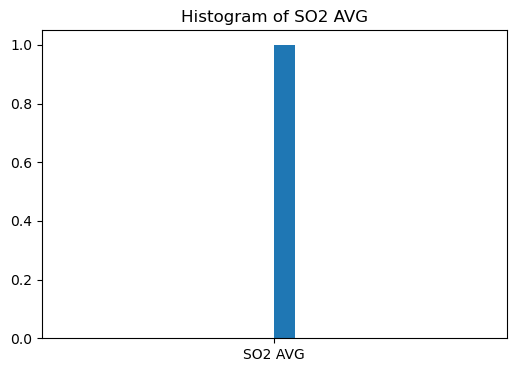

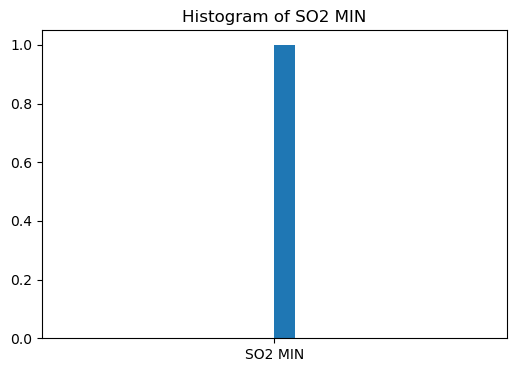

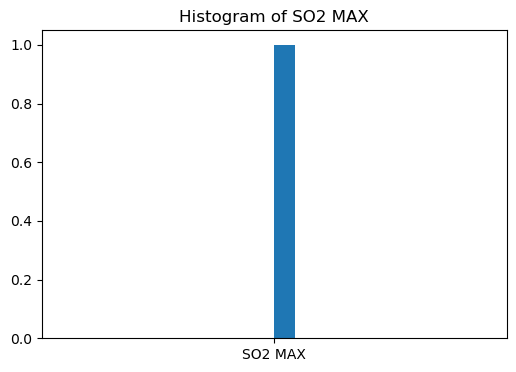

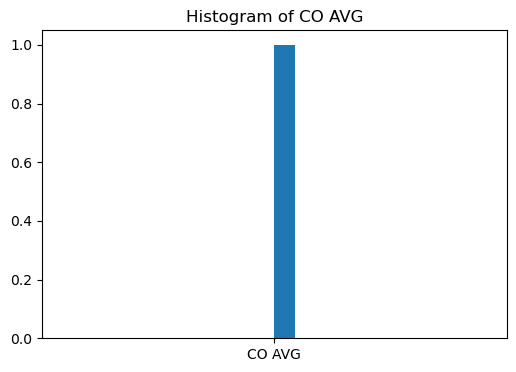

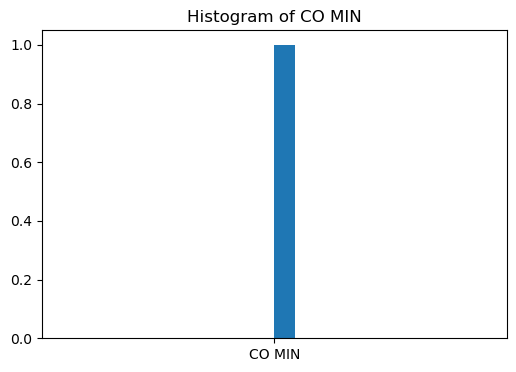

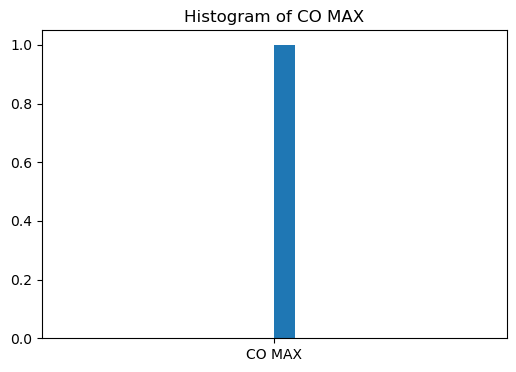

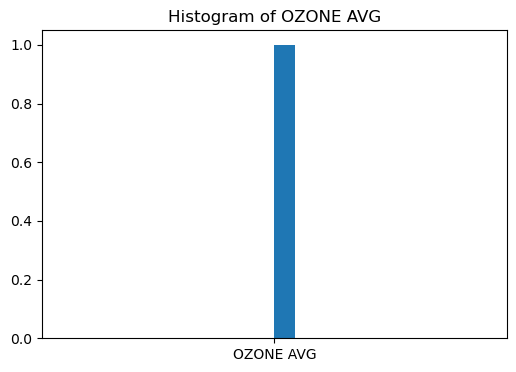

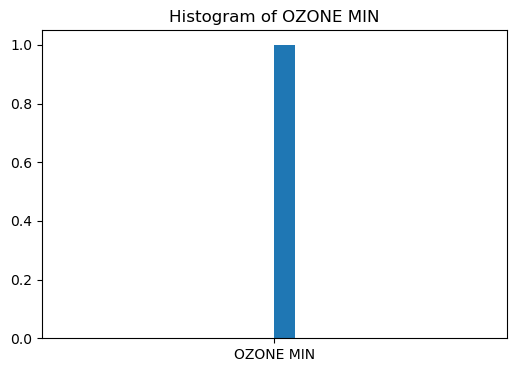

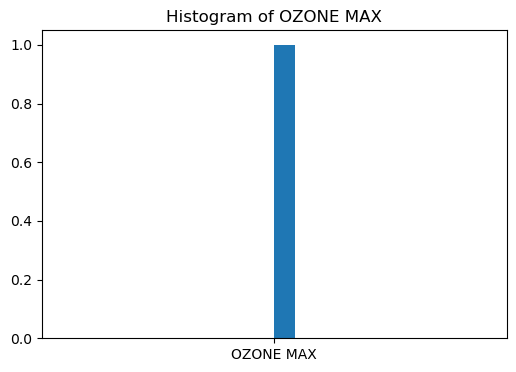

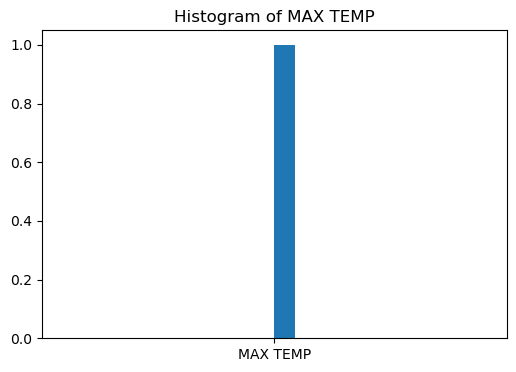

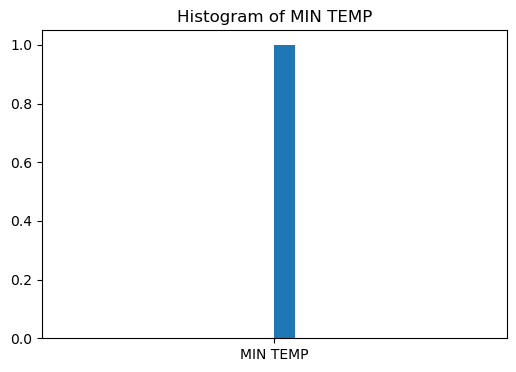

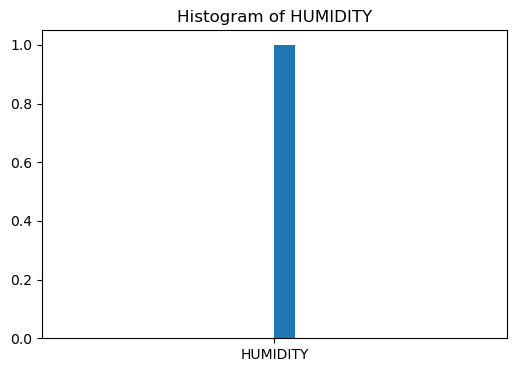

In [45]:
# inspect distribution of variables
to_plot = ['AQI', 'PM2.5 AVG', 'PM2.5 MIN', 'PM2.5 MAX', 'PM10 AVG',
       'PM10 MIN', 'PM10 MAX', 'NO2 AVG', 'NO2 MIN', 'NO2 MAX', 'NH3 AVG',
       'NH3 MIN', 'NH3 MAX', 'SO2 AVG', 'SO2 MIN', 'SO2 MAX', 'CO AVG',
       'CO MIN', 'CO MAX', 'OZONE AVG', 'OZONE MIN', 'OZONE MAX',
 'MAX TEMP', 'MIN TEMP', 'HUMIDITY']

for column in to_plot:
    plt.figure(figsize=(6, 4))  # Adjust the figure size as per your preference
    plt.hist(data=df_poll, x=column, bins=20)
    plt.title(f'Histogram of {column}')
    plt.show()

In [66]:
df_poll['DATE'] = pd.to_datetime(df_poll['DATE'], errors='raise')
df_poll.set_index('DATE', inplace=True)

# Additional Weather DataSet

In [47]:
df_weather

,date,tempmax,tempmin,temp,dew,humidity,windspeed,winddir,sealevelpressure,cloudcover,...,solarenergy,uvindex,sun_duration,condition_Clear,condition_Overcast,condition_Partially_cloudy,condition_Rain,"condition_Rain,_Fog","condition_Rain,_Overcast","condition_Rain,_Partially_cloudy"
0,2017-04-02,39.6,19.0,28.9,5.9,26.7,20.9,309.3,1004.6,0.2,...,25.5,9,751.966667,1,0,0,0,0,0,0
1,2017-04-03,39.6,20.4,29.3,5.7,24.8,12.6,332.1,1005.1,5.1,...,25.1,9,753.833333,1,0,0,0,0,0,0
2,2017-04-04,38.6,23.3,29.6,8.4,29.1,20.2,41.0,1006.9,45.1,...,20.9,9,755.700000,0,0,0,0,0,0,1
3,2017-04-05,36.3,22.3,27.6,13.0,43.8,24.8,138.6,1005.8,57.9,...,17.6,7,757.533333,0,0,0,0,0,0,1
4,2017-04-06,34.6,19.6,26.5,11.8,43.7,35.6,178.8,1000.7,8.7,...,20.8,8,759.383333,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2019-03-27,33.0,15.4,23.7,7.6,38.3,14.0,291.6,1013.5,65.0,...,20.2,8,739.800000,0,0,1,0,0,0,0
725,2019-03-28,36.0,19.7,26.5,10.3,38.1,11.5,329.7,1011.7,73.7,...,21.3,9,741.700000,0,0,1,0,0,0,0
726,2019-03-29,36.8,20.4,27.2,12.9,44.2,14.8,9.0,1008.7,55.3,...,22.4,9,743.566667,0,0,1,0,0,0,0
727,2019-03-30,37.7,20.9,28.2,12.2,40.1,13.3,27.5,1007.8,40.5,...,23.6,9,745.450000,0,0,1,0,0,0,0


In [48]:
# Rain is known to wash away pollutants so we aggregate those features
df_weather['condition_rainy'] = ((df_weather['condition_Rain'] == 1) |
                         (df_weather['condition_Rain,_Fog'] == 1) |
                         (df_weather['condition_Rain,_Overcast'] == 1) |
                         (df_weather['condition_Rain,_Partially_cloudy'] == 1)).astype(int)

In [49]:
df_weather.drop(['condition_Partially_cloudy', 'condition_Rain',
       'condition_Rain,_Fog', 'condition_Rain,_Overcast',
       'condition_Rain,_Partially_cloudy'], axis=1, inplace=True)

In [50]:
df_weather.columns

Index(['date', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'windspeed',
       'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'sun_duration',
       'condition_Clear', 'condition_Overcast', 'condition_rainy'],
      dtype='object')

In [51]:
df_poll

,PM2.5 AVG,PM10 AVG
DATE,,
2017-03-25,75,74
2017-03-26,82,75
2017-03-27,72,71
2017-03-28,78,80
2017-03-29,64,73
...,...,...
2019-03-27,93,86
2019-03-28,103,94
2019-03-29,78,80


In [52]:
# Check index data type
print(df_features.index.dtype)
print(df_poll.index.dtype)
print(df_weather.index.dtype)

datetime64[ns]
datetime64[ns]
int64


# Google Searches Dataframe

In [91]:
df_searches = pd.read_csv(f'{path}merged_google_trends.csv')

In [92]:
df_searches['date'] = pd.to_datetime(df_searches['date'], errors='raise')
df_searches.set_index('date', inplace=True)

In [72]:
df_weather['date'] = pd.to_datetime(df_weather['date'], errors='raise')
df_weather.set_index('date', inplace=True)

In [105]:
df_vehicles['date'] = pd.to_datetime(df_vehicles['date'], errors='raise')
df_vehicles.set_index('date', inplace=True)

In [106]:
df_vehicles

,Registered_Motor_Vehicles
date,
2016-01-01,11349
2016-01-08,11438
2016-01-15,10292
2016-01-22,13464
2016-01-29,12531
...,...
2023-06-02,8539
2023-06-09,7659
2023-06-16,7948


# Consumer Price Index Dataframe

In [344]:
def make_datetime(df_old):
    df = df_old.copy()
    df['date'] = pd.to_datetime(df['date'], errors='raise')
    df.set_index('date', inplace=True)
    return df

In [332]:
#daily data
df_ci = make_datetime(df_ci)



In [345]:
# weekly data
df_india_food_ci = make_datetime(df_india_food_ci)
df_india_alc_ci = make_datetime(df_india_alc_ci)

In [371]:
df_india_alc_ci_distributed = make_datetime(df_india_alc_ci_distributed)

In [367]:
df_india_food_ci_distributed = make_datetime(df_india_food_ci_distributed)

## 2.3 Merge Dataframes

In [372]:
# merge on daily dataframe so weekly dataframes will introduce nan
df_final = df_features.merge(df_weather, how='left', left_index=True, right_index=True)
df_final = df_final.merge(df_poll, how='left', left_index=True, right_index=True)
df_final = df_final.merge(df_searches, how='left', left_index=True, right_index=True)
df_final = df_final.merge(df_vehicles, how='left', left_index=True, right_index=True)
df_final = df_final.merge(df_ci, how='left', left_index=True, right_index=True)
#df_final = df_final.merge(df_india_alc_ci, how='left', left_index=True, right_index=True)
#df_final = df_final.merge(df_india_food_ci, how='left', left_index=True, right_index=True)
df_final = df_final.merge(df_india_alc_ci_distributed, how='left', left_index=True, right_index=True)
df_final = df_final.merge(df_india_food_ci_distributed, how='left', left_index=True, right_index=True)
df_final = df_final.sort_index()

In [378]:
df_final.head(20)

,total_admissions,DURATION_OF_STAY_median,duration_of_intensive_unit_stay_median,Outcome_EXPIRY_sum,Outcome_DAMA_sum,Outcome_DISCHARGE_sum,TLC_median,PLATELETS_median,GLUCOSE_median,UREA_median,...,condition_rainy,PM2.5 AVG,PM2.5 MAX,PM10 AVG,search_HeroDMCHeartInstitute,search_chestpain,Registered_Motor_Vehicles,Average_Consumer_Prices_Industrial_Workers_Ludhiana_Rice,CPI_PanTobacco_and_Intoxicants_India_distributed,CPI_Food_and_Beverages_India_distributed
2017-04-02,15,2.0,0.5,3,1,2,10.40,224.00,152.00,38.00,...,0,53,191,59,100.0,20.0,NaN,1.418116,NaN,NaN
2017-04-03,26,2.5,2.0,2,1,5,9.40,213.50,115.00,29.50,...,0,62,114,70,NaN,NaN,NaN,1.475000,36.35,33.375
2017-04-04,19,3.0,0.0,0,2,12,11.50,237.00,116.00,35.00,...,1,70,100,63,NaN,NaN,NaN,1.475000,NaN,NaN
2017-04-05,8,3.0,2.0,2,0,7,12.30,234.00,140.00,31.00,...,1,88,99,85,NaN,NaN,NaN,1.475000,NaN,NaN
2017-04-06,11,4.0,2.0,0,0,13,10.40,189.00,148.00,59.00,...,0,75,139,69,NaN,NaN,NaN,1.475000,NaN,NaN
2017-04-07,8,5.0,2.0,1,0,9,10.85,228.00,143.50,28.50,...,0,86,112,82,NaN,NaN,27020.0,1.475000,NaN,NaN
2017-04-08,11,4.0,1.0,2,1,15,9.75,249.00,132.70,33.40,...,0,88,173,81,NaN,NaN,NaN,1.475000,NaN,NaN
2017-04-09,8,6.0,4.0,0,0,4,10.20,274.50,138.65,56.00,...,0,87,162,81,0.0,0.0,NaN,1.475000,NaN,NaN
2017-04-10,8,5.0,4.0,1,0,12,12.10,174.50,150.00,64.00,...,0,32,73,31,NaN,NaN,NaN,1.475000,36.35,33.375
2017-04-11,7,4.0,3.0,3,0,5,12.00,230.00,144.00,28.00,...,0,39,50,36,NaN,NaN,NaN,1.475000,NaN,NaN


In [90]:
# Dataframe with features that are replicable for kenya market
df_CDA = df_weather.merge(df_poll, how='left', left_index=True, right_index=True)
df_CDA = df_CDA.merge(df_searches, how='left', left_index=True, right_index=True)
df_CDA['total_admissions'] = df_final['total_admissions']

# WEEKLY DATAFRAME

In [312]:
df_daily = df_final.copy()

In [318]:
# Shift the daily dataframe by seven days forward.
df_daily_shifted = df_daily.shift(7)

# Now, resample the shifted daily dataframe to the weekly frequency.
# The 'last' method ensures that we're getting the last observation in each week.
df_daily_resampled = df_daily_shifted.resample('W').last()


In [376]:
# Fill NaN values with the last observed non-NaN values (forward fill)
df_final_filled = df_final.fillna(method='ffill')

# Define lists of columns for different aggregation methods
max_cols = ['tempmax', 'PM2.5 MAX']
min_cols = ['tempmin']
sum_cols = ['Outcome_EXPIRY_sum', 'Outcome_DAMA_sum', 'Outcome_DISCHARGE_sum', 'SMOKING__sum', 'ALCOHOL_sum',
            'DM_sum', 'HTN_sum', 'PRIOR_CMP_sum', 'readmissions_sum', 'CKD_sum', 'SEVERE_ANAEMIA_sum', 'ANAEMIA_sum',
            'STABLE_ANGINA_sum', 'ACS_sum', 'STEMI_sum', 'ATYPICAL_CHEST_PAIN_sum', 'HEART_FAILURE_sum', 'HFREF_sum',
            'HFNEF_sum', 'VALVULAR_sum', 'CAD_sum', 'total_admissions', 'condition_rainy', 'TYPE_OF_ADMISSION_EMERGENCY_OPD_sum']
mean_cols = ['temp', 'dew', 'humidity', 'windspeed', 'winddir', 'sealevelpressure', 'PM10 AVG', 'PM2.5 AVG', 'visibility',
             'TLC_median', 'PLATELETS_median', 'GLUCOSE_median', 'UREA_median', 'CREATININE_median', 'BNP_median','solarenergy', 'uvindex','tempmin',
             'sun_duration', 'cloudcover', 'male_ratio', 'rural_ratio', 'Average_Consumer_Prices_Industrial_Workers_Ludhiana_Rice',
             'EF_median', 'HB_mean', 'DURATION_OF_STAY_median', 'duration_of_intensive_unit_stay_median', 'average_age']

# Aggregate the dataframe on a weekly basis
df_weekly = pd.DataFrame()
df_weekly[max_cols] = df_final_filled[max_cols].resample('W').max()
df_weekly[sum_cols] = df_final_filled[sum_cols].resample('W').sum()
df_weekly[mean_cols] = df_final_filled[mean_cols].resample('W').mean()

# For the 'male_ratio' and 'rural_ratio' columns, calculate the mean of the daily ratios within each week
df_weekly[['male_ratio', 'rural_ratio']] = df_final_filled[['male_ratio', 'rural_ratio']].resample('W').mean()

# For 'search_HeroDMCHeartInstitute' and 'search_chestpain', use the last value of each week ending on Sunday
df_weekly[['search_HeroDMCHeartInstitute',  'search_chestpain']] = df_final_filled[['search_HeroDMCHeartInstitute', 'search_chestpain']].resample('W-SUN').last()

# For 'Registered_Motor_Vehicles', use the last value of each week ending on Sunday
df_weekly[['Registered_Motor_Vehicles', 'CPI_PanTobacco_and_Intoxicants_India_distributed', 'CPI_Food_and_Beverages_India_distributed']] = df_final_filled[['Registered_Motor_Vehicles', 'CPI_Food_and_Beverages_India_distributed', 'CPI_PanTobacco_and_Intoxicants_India_distributed']].resample('W-SUN').last()

print(df_weekly.isna().sum())
df_weekly.dropna(inplace=True)
df_weekly

tempmax                                                     0
PM2.5 MAX                                                   0
Outcome_EXPIRY_sum                                          0
Outcome_DAMA_sum                                            0
Outcome_DISCHARGE_sum                                       0
SMOKING__sum                                                0
ALCOHOL_sum                                                 0
DM_sum                                                      0
HTN_sum                                                     0
PRIOR_CMP_sum                                               0
readmissions_sum                                            0
CKD_sum                                                     0
SEVERE_ANAEMIA_sum                                          0
ANAEMIA_sum                                                 0
STABLE_ANGINA_sum                                           0
ACS_sum                                                     0
STEMI_su

,tempmax,PM2.5 MAX,Outcome_EXPIRY_sum,Outcome_DAMA_sum,Outcome_DISCHARGE_sum,SMOKING__sum,ALCOHOL_sum,DM_sum,HTN_sum,PRIOR_CMP_sum,...,EF_median,HB_mean,DURATION_OF_STAY_median,duration_of_intensive_unit_stay_median,average_age,search_HeroDMCHeartInstitute,search_chestpain,Registered_Motor_Vehicles,CPI_PanTobacco_and_Intoxicants_India_distributed,CPI_Food_and_Beverages_India_distributed
2017-04-09,39.6,173,7,4,65,5,5,23,42,12,...,42.921429,12.681011,3.928571,1.857143,58.893574,0.0,0.0,27020.0,33.375,36.350
2017-04-16,44.8,158,14,1,46,3,3,18,17,15,...,39.128571,12.719145,4.357143,2.214286,56.705035,0.0,54.0,13709.0,33.375,36.350
2017-04-23,45.4,294,16,2,46,9,13,35,47,22,...,38.121429,12.519121,4.857143,2.357143,62.537807,0.0,59.0,12122.0,33.375,36.350
2017-04-30,40.5,298,8,9,145,20,25,80,87,31,...,39.892857,12.531962,3.928571,1.214286,59.461379,0.0,46.0,11646.0,33.375,36.350
2017-05-07,45.0,169,9,3,116,14,22,67,67,33,...,40.900000,12.324302,5.142857,2.785714,59.447659,0.0,0.0,11844.0,26.740,29.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-03,23.5,449,7,9,132,5,6,24,85,21,...,42.892857,12.262284,5.214286,3.071429,63.826071,0.0,59.0,10509.0,34.375,40.850
2019-03-10,26.4,428,6,8,138,1,2,12,65,19,...,50.128571,11.841357,6.142857,3.071429,63.084348,0.0,20.0,10638.0,34.525,40.875
2019-03-17,28.9,318,9,19,123,2,4,32,80,19,...,46.871429,11.948393,5.428571,3.000000,61.116381,18.0,0.0,11039.0,34.525,40.875
2019-03-24,30.4,472,9,13,114,3,4,21,69,20,...,41.278571,12.009904,4.857143,2.428571,62.472931,15.0,0.0,9764.0,34.525,40.875


In [354]:
# k-NN for missing values
from sklearn.impute import KNNImputer

# Create a KNN Imputer
imputer = KNNImputer(n_neighbors=10)

# Define columns to impute
columns_to_impute = ['search_HeroDMCHeartInstitute', 'search_chestpain', 'Registered_Motor_Vehicles' ]

# Apply the imputer
df_weekly[columns_to_impute] = imputer.fit_transform(df_weekly[columns_to_impute])

In [324]:
df_weekly = df_weekly.merge(df_daily_resampled[sum_cols], left_index=True, right_index=True, suffixes=('', '_prev_day'))

In [377]:
#df_final.to_csv(f'{path}final_dataset_hospital_admission_Ludhiana_2017-2019_ALL-FEATURES-EMERGENCYONLY.csv')
df_weekly.to_csv(f'{path}final_dataset_hospital_admission_Ludhiana_2017-2019_ALL-FEATURES_weekly_TEST.csv')
#df_weekly.to_csv(f'{path}final_dataset_hospital_admission_Ludhiana_2017-2019_ALL-FEATURES-EMERGENCYONLY_weekly.csv')

#df_CDA.to_csv(f'{path}final_dataset_hospital_admission_Ludhiana_2017-2019_CDA-MODELLING-FEATURES.csv')